In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from google.colab import drive
import zipfile
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)



Tue Jan 26 08:36:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
drive.mount('/content/drive')
txtzip_dir = '/content/drive/My Drive/' + 'Flickr8k_text' + '.zip'
zipfile.ZipFile(txtzip_dir, 'r').extractall()
txtzip_dir = '/content/drive/My Drive/' + 'Flickr8k_Dataset' + '.zip'
zipfile.ZipFile(txtzip_dir, 'r').extractall()


Mounted at /content/drive


In [3]:
from PIL import Image
import numpy as np

class DataSet(torch.utils.data.Dataset):
    def __init__(self):

        self.imgs = os.listdir('./Flicker8k_Dataset')[: 8000]
        self.test_imgs = os.listdir('./Flicker8k_Dataset')[8000:8091]

        self.descriptions = dict()
        # https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926
        with open('./Flickr8k.token.txt') as f:
            data = f.read()
            try:
                for el in data.split("\n"):
                    tokens = el.split()
                    if len(tokens) > 1:
                        image_id , image_desc = tokens[0],tokens[1:]
                    image_id = image_id.split(".")[0]
                    if image_id in self.descriptions:
                        self.descriptions[image_id].append(image_desc)
                    else:
                        self.descriptions[image_id] = list()
                        self.descriptions[image_id].append(image_desc)
            except Exception as e: 
                print("Exception got :- \n",e)



    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(os.path.join('./Flicker8k_Dataset', self.imgs[idx]))
        img_id = os.path.splitext(self.imgs[idx])[0]
        img = img.resize((299, 299))
        caption = self.descriptions[img_id]
        caption = caption[np.random.randint(len(caption))]
        return np.array(img), caption

    def get_test_data(self, idx):
        img = Image.open(os.path.join('./Flicker8k_Dataset', self.test_imgs[idx]))
        img_id = os.path.splitext(self.test_imgs[idx])[0]
        img = img.resize((299, 299))
        captions = self.descriptions[img_id]
        return np.array(img), captions


dataset = DataSet()

In [5]:
import itertools

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}

    def build(self, wordlist, min_freq):
        wordlist = list(itertools.chain.from_iterable(wordlist))
        wordlist = list(itertools.chain.from_iterable(wordlist))

        wordfreq = {}

        for word in wordlist:
            w = word.lower()
            if not w in wordfreq:
                wordfreq[w] = 1
            else :
                wordfreq[w] += 1
        
        newlist = []
        for word, freq in wordfreq.items():
            if freq >= min_freq:
                newlist.append(word)


        self.word2idx['<sos>'] = 0
        self.idx2word[0] = '<sos>'
        self.word2idx['<eos>'] = 1
        self.idx2word[1] = '<eos>'
        self.word2idx['<unk>'] = 2
        self.idx2word[2] = '<unk>'
        self.word2idx['<pad>'] = 3
        self.idx2word[3] = '<pad>'
        idx = 4
        for word in newlist:
            if not word in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx +=1


    def wtoi(self, word):
        word = word.lower()
        if word in self.word2idx:
            return self.word2idx[word]
        else :
            return 2

    def itow(self, idx):
        return self.idx2word[idx]


    def caption2idxlist(self, caption):
        idxlist = [0]
        for word in caption:
            idxlist.append(self.wtoi(word))
        idxlist += [1]
        return idxlist

    def idxlist2caption(self, idxlist):
        caption = []
        for idx in idxlist:
            caption.append(self.idx2word[idx])
        return caption


    def pack_and_pad(self, caption_list):
        idxlist_list = []
        max_len = 0
        for caption in caption_list:
            idxlist = self.caption2idxlist(caption)
            if len(idxlist) > max_len:
                max_len = len(idxlist)
            idxlist_list.append(idxlist)

        for i in range(len(idxlist_list)):
            num_pad = max_len - len(idxlist_list[i])
            if num_pad > 0:
                idxlist_list[i] += [3] * num_pad

        return idxlist_list


vocab = Vocabulary()
vocab.build(dataset.descriptions.values(), 5)


In [6]:
from torch.utils.data import DataLoader

def pad_and_pack(batch):
    batch_x = []
    batch_y = []
    for (x, y) in batch:
        batch_x.append(x)
        batch_y.append(y)
    batch_x = np.array(batch_x)
    batch_y = vocab.pack_and_pad(batch_y)
    batch_y = np.array(batch_y)
    return  batch_x, batch_y

    

loader = DataLoader(dataset=dataset, batch_size=16, shuffle=True, drop_last=True, collate_fn=pad_and_pack)

In [7]:
INCEPTION = models.inception_v3(pretrained=True, progress=False, aux_logits=False).to(device)
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

INCEPTION.fc = Identity()
INCEPTION
for param in INCEPTION.parameters():
    param.requires_grad = False

def img_to_vec2048(x):
    with torch.no_grad():
        x = INCEPTION(x) 
    return x



Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [16]:
def xavier_weight(*size):
    return torch.nn.init.xavier_uniform_(torch.empty(*size))

class Decoder(nn.Module):
    def __init__(self, n_vocab, n_feature, n_emb, n_layers):
        super().__init__()
        self.rnn = nn.ModuleList([
            nn.LSTMCell(n_emb, n_emb) for _ in range(n_layers)
        ])

        self.embed = nn.Embedding(n_vocab, n_emb)
        self.emb_drop = nn.Dropout(0.5)

        self.tologits = nn.Linear(n_emb, n_vocab)
        self.feature2hidden = nn.Linear(n_feature, n_emb * n_layers)
        self.x0 = nn.Parameter(xavier_weight(1, n_emb), requires_grad=True)
        self.c0 = nn.Parameter(xavier_weight(n_layers, 1, n_emb), requires_grad=True)
        self.n_layers = n_layers
        self.n_emb = n_emb
    

    def forward(self, feature, captions, teaching_force_ratio):
        nb, num_sq = captions.size()
        h_prev = self.feature2hidden(feature).view(-1, self.n_layers, self.n_emb).transpose(0, 1).contiguous()
        c_prev = self.c0.expand(-1, nb, -1)
        x = self.x0.expand(nb, -1)        
        logits = []
        for sq in range(num_sq):
            out , h_prev, c_prev = self._rnn(x, h_prev, c_prev)
            out = self.tologits(out)
            logits.append(out)

            if np.random.rand() < teaching_force_ratio :
                x = self.emb_drop(self.embed(captions[:, sq]))
            
            else:
                x = self.emb_drop(self.embed(torch.argmax(out, dim=1)))

        return torch.stack(logits, dim=1)



    def _rnn(self, x, h_prev, c_prev):
        h_curr = []
        c_curr = []
        for i, cell in enumerate(self.rnn):
            h, c = cell(x, (h_prev[i], c_prev[i]))
            h_curr.append(h)
            c_curr.append(c)
            x = x + h
        return x, h_curr, c_curr



    def test(self, feature, max_len):
        self.eval()

        nb, _ = feature.size()
        h_prev = self.feature2hidden(feature).view(-1, self.n_layers, self.n_emb).transpose(0, 1).contiguous()
        c_prev = self.c0.expand(-1, nb, -1)
        x = self.x0.expand(nb, -1)        
        logits = []
        for sq in range(max_len):
            out , h_prev, c_prev = self._rnn(x, h_prev, c_prev)
            out = self.tologits(out)
            logits.append(out)
            x = self.emb_drop(self.embed(torch.argmax(out, dim=1)))

        logits = torch.stack(logits, dim=1)
        predicted = torch.argmax(logits, dim=2)

        self.train()
        return predicted



In [29]:
dec = Decoder(n_vocab=len(vocab.word2idx), n_feature=2048, n_emb=256, n_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<pad>'])
solver = optim.Adam(dec.parameters(), 5e-4)

In [30]:
num_epochs = 20
for epoch in range(num_epochs):
    for x, y in loader:
        solver.zero_grad()
        x = torch.Tensor(x).permute(0, 3, 1, 2).to(device) / 128. - 1.0
        x = img_to_vec2048(x)
        y = torch.from_numpy(y).long().to(device)
        logits = dec(x, y, 1.0)
        loss = criterion(logits.transpose(1, 2).contiguous(), y)
        loss.backward()
        solver.step()
    print(loss.item())


3.579023599624634
3.3791425228118896
2.9789845943450928
3.1146016120910645
2.973710536956787
2.9464914798736572
2.6741409301757812
2.882075309753418
2.7923829555511475
2.625828981399536
2.5545923709869385
2.540755033493042
2.872260808944702
2.309096097946167
2.4459786415100098
2.4728269577026367
2.442356586456299
2.5324456691741943
2.4089839458465576
2.2897233963012695


In [38]:
num_epochs = 20
for epoch in range(num_epochs):
    for x, y in loader:
        solver.zero_grad()
        x = torch.Tensor(x).permute(0, 3, 1, 2).to(device) / 128. - 1.0
        x = img_to_vec2048(x)
        y = torch.from_numpy(y).long().to(device)
        logits = dec(x, y, 1.0)
        loss = criterion(logits.transpose(1, 2).contiguous(), y)
        loss.backward()
        solver.step()
    print(loss.item())


2.4666802883148193
2.417503595352173
2.3747220039367676
2.718761682510376
2.4766616821289062
2.299144983291626
2.536761999130249
2.4455983638763428
2.5390608310699463
2.3463780879974365
2.4885733127593994
2.28706955909729
2.4658968448638916
2.4048569202423096
2.364057779312134
2.440808057785034
2.251723051071167
2.3232569694519043
2.455998182296753
2.451199531555176


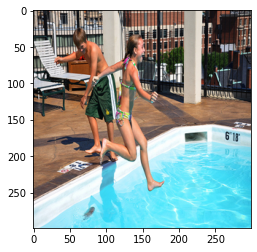

<sos> a man in a blue shirt is sitting on a bench with a fishing pole . <eos> 

In [45]:
import matplotlib.pyplot as plt

def test(data_index, use_test_data=True):
    if use_test_data:
        np_test_img, caption = dataset.get_test_data(data_index)
    else :
        np_test_img, caption = dataset.__getitem__(data_index)


    test_image = torch.Tensor(np_test_img).unsqueeze(0).permute(0, 3, 1, 2).to(device) / 128.0 - 1.0
    test_feature = img_to_vec2048(test_image)


    output = dec.test(test_feature, max_len=50)
    output = output.squeeze(0).detach().cpu().numpy()
    
    plt.imshow(np_test_img)
    plt.show()
    predicted = vocab.idxlist2caption(output)
    for tok in predicted:
        print(tok, end=' ')
        if tok == '<eos>':
            break

    
test(2, True)

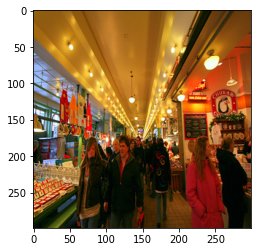

<sos> a woman in a red shirt is standing in front of a large waterfall . <eos> 

In [46]:

test(12, True)

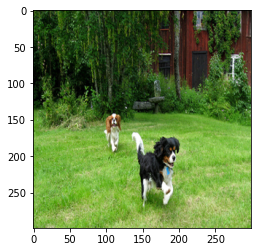

<sos> a dog is jumping over a hurdle . <eos> 

In [48]:

test(22, True)

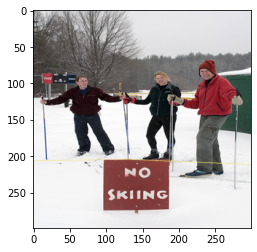

<sos> a girl in a pink bathing suit is playing in a puddle . <eos> 

In [49]:

test(32, True)

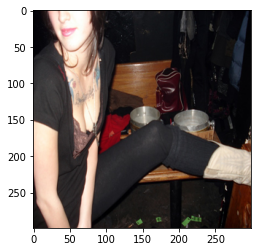

<sos> a boy in a red shirt is playing with a <unk> . <eos> 

In [50]:

test(42, True)

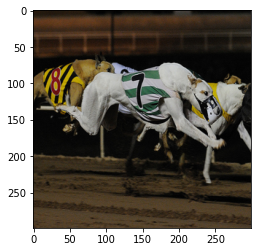

<sos> a man in a blue shirt is standing in front of a large waterfall . <eos> 

In [51]:

test(52, True)

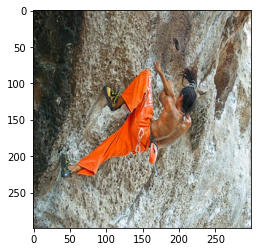

<sos> a man in a blue shirt is standing on a rock with a <unk> in the background . <eos> 

In [52]:

test(62, True)